## Carhart's Four-Factor
$E(r_i)-r_f = \alpha + \beta_{mkt}MKT + \beta_{smb}SMB + \beta_{hml}HML + \beta_{wml}WML$

In [1]:
import yfinance as yf 
import numpy as np 
import pandas_datareader.data as web 
import matplotlib.pyplot as plt 
import statsmodels.formula.api as smf 
from pandas_datareader.famafrench import get_available_datasets

plt.style.use('bmh')

In [2]:
data = yf.download('AMZN', period='10y', interval='1d', auto_adjust=True, progress=False)
data = data.Close.resample('M').last().iloc[:-1]
data = np.log(data/data.shift(1))
data.dropna(inplace=True)
data

Date
2012-03-31    0.119556
2012-04-30    0.135517
2012-05-31   -0.085437
2012-06-30    0.070010
2012-07-31    0.021446
                ...   
2021-09-30   -0.055003
2021-10-31    0.026255
2021-11-30    0.039147
2021-12-31   -0.050506
2022-01-31   -0.108510
Freq: M, Name: Close, Length: 119, dtype: float64

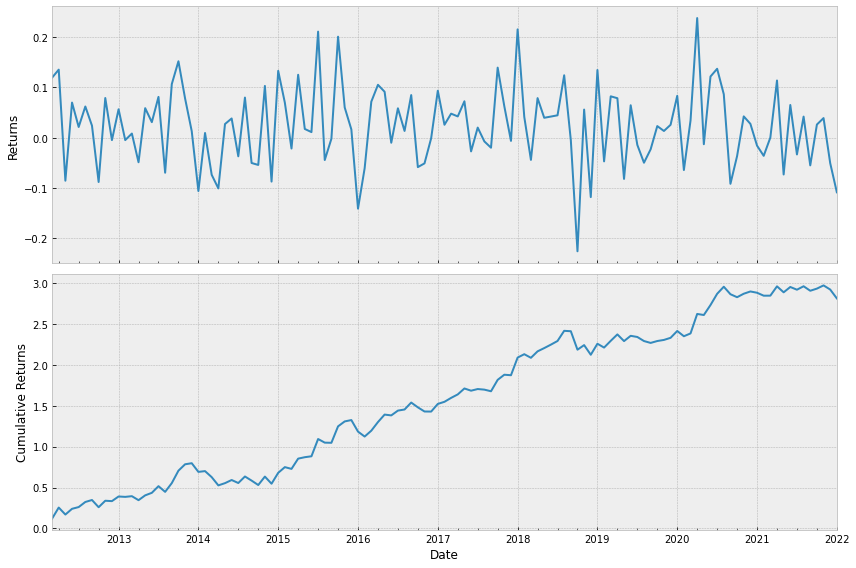

In [3]:
fig, ax = plt.subplots(2,1, figsize=(12,8), sharex=True)

data.plot(ax=ax[0], ylabel='Returns')
data.cumsum().plot(ax=ax[1], ylabel='Cumulative Returns')

plt.tight_layout()
plt.show()

In [4]:
factors_list = get_available_datasets()
for factor in factors_list:
    if 'F-F' in factor: print(factor)

F-F_Research_Data_Factors
F-F_Research_Data_Factors_weekly
F-F_Research_Data_Factors_daily
F-F_Research_Data_5_Factors_2x3
F-F_Research_Data_5_Factors_2x3_daily
F-F_Momentum_Factor
F-F_Momentum_Factor_daily
F-F_ST_Reversal_Factor
F-F_ST_Reversal_Factor_daily
F-F_LT_Reversal_Factor
F-F_LT_Reversal_Factor_daily


In [5]:
ff_factors = web.DataReader('F-F_Research_Data_Factors', 'famafrench', 
                            start=data.index[0], end=data.index[-1])[0]
ff_momentum = web.DataReader('F-F_Momentum_Factor', 'famafrench',
                             start=data.index[0], end=data.index[-1])[0]
factors = ff_factors.join(ff_momentum)
factors = factors.div(100)
factors

,Mkt-RF,SMB,HML,RF,Mom
Date,,,,,
2012-03,0.0311,-0.0066,0.0112,0.0000,0.0130
2012-04,-0.0085,-0.0041,-0.0077,0.0000,0.0375
2012-05,-0.0619,0.0009,-0.0106,0.0001,0.0649
2012-06,0.0389,0.0064,0.0059,0.0000,-0.0106
2012-07,0.0079,-0.0272,-0.0012,0.0000,0.0302
...,...,...,...,...,...
2021-08,0.0290,-0.0048,-0.0013,0.0000,0.0252
2021-09,-0.0437,0.0080,0.0509,0.0000,0.0157
2021-10,0.0665,-0.0228,-0.0044,0.0000,0.0321


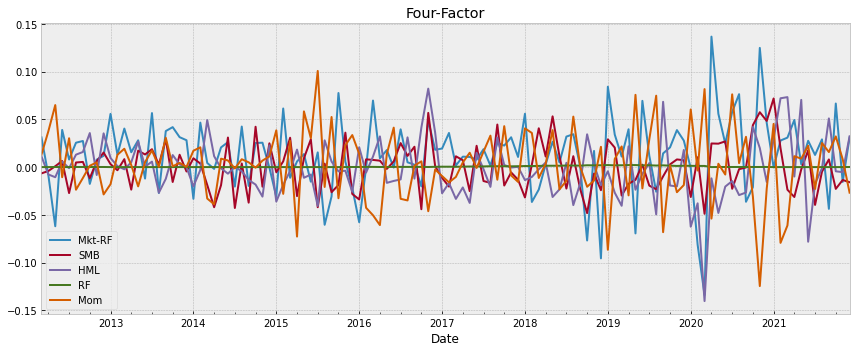

In [6]:
factors.plot(figsize=(12,5), title='Four-Factor')
plt.tight_layout()
plt.show()

In [7]:
factors.index = factors.index.format()
data.index = data.index.strftime('%Y-%m')

In [8]:
datas = factors.join(data, how='inner')
datas.rename(columns={'Close':'returns', 'Mkt-RF':'MKT'}, inplace=True)
datas['excess_returns'] = datas['returns'] - datas['RF']
datas.columns = [col.strip() for col in datas.columns]
datas

,MKT,SMB,HML,RF,Mom,returns,excess_returns
2012-03,0.0311,-0.0066,0.0112,0.0000,0.0130,0.119556,0.119556
2012-04,-0.0085,-0.0041,-0.0077,0.0000,0.0375,0.135517,0.135517
2012-05,-0.0619,0.0009,-0.0106,0.0001,0.0649,-0.085437,-0.085537
2012-06,0.0389,0.0064,0.0059,0.0000,-0.0106,0.070010,0.070010
2012-07,0.0079,-0.0272,-0.0012,0.0000,0.0302,0.021446,0.021446
...,...,...,...,...,...,...,...
2021-08,0.0290,-0.0048,-0.0013,0.0000,0.0252,0.042134,0.042134
2021-09,-0.0437,0.0080,0.0509,0.0000,0.0157,-0.055003,-0.055003
2021-10,0.0665,-0.0228,-0.0044,0.0000,0.0321,0.026255,0.026255
2021-11,-0.0155,-0.0135,-0.0053,0.0000,0.0082,0.039147,0.039147


In [9]:
model = smf.ols(formula='excess_returns ~ MKT + SMB + HML + Mom', data=datas).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         excess_returns   R-squared:                       0.491
Model:                            OLS   Adj. R-squared:                  0.472
Method:                 Least Squares   F-statistic:                     27.20
Date:                Wed, 23 Feb 2022   Prob (F-statistic):           8.13e-16
Time:                        14:11:42   Log-Likelihood:                 174.37
No. Observations:                 118   AIC:                            -338.7
Df Residuals:                     113   BIC:                            -324.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0045      0.006      0.811      0.4